In [ ]:
import sys, os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm 

In [ ]:
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.connect_db import run_query, close_tunnel

# --- Läs in basdata (kohort) ---
sql_path = PROJECT_ROOT / "sql" / "stroke_cci_ps_cohort.sql"
with open(sql_path, encoding="utf-8") as f:
    cohort_sql = f.read()

df_base = run_query(cohort_sql)
print("df_base kolumner:", df_base.columns.tolist())
print("df_base antal rader:", len(df_base))

# --- Läs in kovariater (första 24h) ---
sql_path = PROJECT_ROOT / "sql" / "stroke_covariates_first24h.sql"
with open(sql_path, encoding="utf-8") as f:
    cov_sql = f.read()

df_cov = run_query(cov_sql)
print("df_cov kolumner:", df_cov.columns.tolist())
print("df_cov antal rader:", len(df_cov))

c:\Users\enaam\.conda\envs\mimicenv\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\enaam\.conda\envs\mimicenv\Lib\site-packages\paramiko\transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,
2026-02-03 12:42:19,775| ERROR   | Password is required for key C:\Users\enaam/.ssh\id_rsa


SSH-tunnel startad på lokal port: 52441
df_base kolumner: ['subject_id', 'hadm_id', 'admittime', 'gender', 'anchor_age', 'dod', 'died', 'died_30d', 'died_90d', 'died_1y', 'cci_score', 'high_cci']
df_base antal rader: 4747
df_cov kolumner: ['subject_id', 'hadm_id', 'admittime', 'anchor_age', 'gender', 'creatinine_first', 'glucose_first', 'sodium_first', 'bun_first', 'bun_cr_ratio_first', 'has_creatinine', 'has_glucose', 'has_sodium', 'has_bun']
df_cov antal rader: 4747


In [ ]:
# Säkerställ att outcome-kolumnerna är 0/1 (ibland kommer bool)
outcome_cols = ["died", "died_30d", "died_90d", "died_1y"]
for c in outcome_cols:
    if c in df_base.columns and df_base[c].dtype == "bool":
        df_base[c] = df_base[c].astype(int)

# Antal döda per CCI-grupp (0=CCI≤5, 1=CCI>5)
counts = df_base.groupby("high_cci")[outcome_cols].sum().astype(int)
counts.index = counts.index.map({0: "CCI ≤ 5", 1: "CCI > 5"})

# Totalt antal patienter per grupp
counts["n_patients"] = df_base.groupby("high_cci").size().astype(int).values

# Snygg ordning
counts = counts[["n_patients", "died", "died_30d", "died_90d", "died_1y"]]
display(counts)

,n_patients,died,died_30d,died_90d,died_1y
high_cci,,,,,
CCI ≤ 5,4100,1259,563,780,1042
CCI > 5,647,384,164,228,321


In [ ]:
# Duplikatkontroll
dup_base = df_base.duplicated(subset=["hadm_id"]).sum() if "hadm_id" in df_base.columns else np.nan
dup_cov  = df_cov.duplicated(subset=["hadm_id"]).sum()  if "hadm_id" in df_cov.columns else np.nan
print("Duplikat hadm_id i df_base:", dup_base)
print("Duplikat hadm_id i df_cov:", dup_cov)

# Missingness i labb
lab_cols = ["creatinine_first","glucose_first","sodium_first","bun_first"]
print("\nMissingness (antal NaN) i df_cov:")
display(df_cov[lab_cols].isna().sum())

print("\nSanity check describe (df_cov):")
show_cols = ["anchor_age"] + lab_cols
show_cols = [c for c in show_cols if c in df_cov.columns]
display(df_cov[show_cols].describe())


Duplikat hadm_id i df_base: 0
Duplikat hadm_id i df_cov: 0

Missingness (antal NaN) i df_cov:


creatinine_first    445
glucose_first       470
sodium_first        456
bun_first           446
dtype: int64


Sanity check describe (df_cov):


,anchor_age,creatinine_first,glucose_first,sodium_first,bun_first
count,4747.000000,4302.000000,4277.000000,4291.000000,4301.000000
mean,67.514430,1.233101,135.494038,139.308553,21.627993
std,14.720416,1.231838,66.951620,4.215729,16.183460
min,18.000000,0.200000,31.000000,113.000000,3.000000
25%,58.000000,0.700000,96.000000,137.000000,13.000000
50%,69.000000,0.900000,115.000000,139.000000,17.000000
75%,79.000000,1.200000,151.000000,142.000000,24.000000
max,91.000000,18.200000,1267.000000,167.000000,189.000000


In [ ]:
# =========================
# GEMENSAMT: Merge basdata + 24h-labb
# =========================

lab_keep = ["hadm_id","creatinine_first","glucose_first","sodium_first","bun_first"]
missing_keep = [c for c in lab_keep if c not in df_cov.columns]
if missing_keep:
    raise ValueError(f"Saknar kolumner i df_cov: {missing_keep}")

# validate="one_to_one" hjälper dig fånga dubbletter som annars förstör N
df_ps = df_base.merge(df_cov[lab_keep], on="hadm_id", how="left", validate="one_to_one")

if "gender" not in df_ps.columns:
    raise ValueError("Saknar 'gender' i df_ps efter merge. Kontrollera df_base.")

df_ps["is_male"] = (df_ps["gender"] == "M").astype(int)

# säkerställ numeriskt (så SMD/PS inte kraschar pga text)
df_ps["anchor_age"] = pd.to_numeric(df_ps["anchor_age"], errors="coerce")
for c in ["bun_first","creatinine_first","glucose_first","sodium_first"]:
    df_ps[c] = pd.to_numeric(df_ps[c], errors="coerce")

df_ps["high_cci"] = pd.to_numeric(df_ps["high_cci"], errors="coerce").astype(int)

print("df_ps antal rader (ska vara samma i V2 och V3):", len(df_ps))
print("NaN i labb efter merge:")
display(df_ps[["creatinine_first","glucose_first","sodium_first","bun_first"]].isna().sum())


df_ps antal rader (ska vara samma i V2 och V3): 4747
NaN i labb efter merge:


creatinine_first    445
glucose_first       470
sodium_first        456
bun_first           446
dtype: int64

In [ ]:
# =========================
# GEMENSAMT: Behåll en rå kopia (ändra aldrig denna)
# =========================
df_raw = df_ps.copy()

print("RÅ N:", len(df_raw))


RÅ N: 4747


In [ ]:
# =========================
# GEMENSAMT: Kontrollera att merge inte ändrat N
# =========================
print("N df_base:", len(df_base))
print("N df_raw :", len(df_raw))

if len(df_base) != len(df_raw):
    print("⚠️ OBS: merge gav annan N än df_base. Kontrollera dubbletter/validate.")


N df_base: 4747
N df_raw : 4747


In [ ]:
# =========================
# VARIANT 2: Medianimputering (ingen log)
# =========================

df_v2 = df_raw.copy()
lab_cols = ["creatinine_first","glucose_first","sodium_first","bun_first"]

missing_before = df_v2[lab_cols].isna().sum().copy()

for c in lab_cols:
    df_v2[c] = df_v2[c].astype(float)
    df_v2[c] = df_v2[c].fillna(df_v2[c].median(skipna=True))

missing_after = df_v2[lab_cols].isna().sum().copy()

print("Missingness efter imputering (ska vara 0):")
display(missing_after)

Missingness efter imputering (ska vara 0):


creatinine_first    0
glucose_first       0
sodium_first        0
bun_first           0
dtype: int64

In [ ]:
use_covars_v2 = ["anchor_age","is_male","creatinine_first","glucose_first","sodium_first","bun_first"]

X = df_v2[use_covars_v2].astype(float).copy()
X = X.replace([np.inf, -np.inf], np.nan)
for c in X.columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

y = df_v2["high_cci"].astype(int).values

clf = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000)
clf.fit(X.values, y)

df_v2["ps_v2"] = clf.predict_proba(X.values)[:, 1]
df_v2["ps_stratum10_v2"] = pd.qcut(df_v2["ps_v2"], q=10, labels=False, duplicates="drop")

print("ps_v2 min/max:", float(df_v2["ps_v2"].min()), float(df_v2["ps_v2"].max()))
display(pd.crosstab(df_v2["ps_stratum10_v2"], df_v2["high_cci"]))


ps_v2 min/max: 0.03962683472147438 0.9727447422860955


high_cci,0,1
ps_stratum10_v2,,
0,465,10
1,446,29
2,449,25
3,444,31
4,435,40
5,423,51
6,418,57
7,389,85
8,345,130


In [ ]:
def smd_cont(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    sp = np.sqrt((a.var(ddof=1) + b.var(ddof=1)) / 2)
    return (a.mean() - b.mean()) / sp if sp > 0 else np.nan

def smd_bin(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    p = (a.mean() + b.mean()) / 2
    sp = np.sqrt(p * (1 - p))
    return (a.mean() - b.mean()) / sp if sp > 0 else np.nan

vars_base = ["anchor_age","is_male","bun_first","creatinine_first","glucose_first","sodium_first"]

t = df_v2[df_v2["high_cci"]==1]
c = df_v2[df_v2["high_cci"]==0]

rows = []
for v in vars_base:
    mean_c = float(c[v].mean())
    mean_t = float(t[v].mean())
    smd = smd_bin(t[v], c[v]) if v=="is_male" else smd_cont(t[v], c[v])
    rows.append([v, mean_c, mean_t, float(smd)])

tab_baseline_v2 = pd.DataFrame(rows, columns=["Variabel","Kontroll (CCI≤5)","Behandling (CCI>5)","SMD_pre"])
display(tab_baseline_v2)


,Variabel,Kontroll (CCI≤5),Behandling (CCI>5),SMD_pre
0,anchor_age,67.235122,69.284389,0.147948
1,is_male,0.500244,0.556414,0.112521
2,bun_first,19.389512,32.622875,0.707298
3,creatinine_first,1.082951,1.955487,0.599960
4,glucose_first,130.679268,151.117465,0.285515
5,sodium_first,139.337317,138.908810,-0.102609


In [ ]:
outcomes = ["died_30d","died_90d","died_1y"]

rows = []
for oc in outcomes:
    d = df_v2.dropna(subset=[oc, "high_cci"]).copy()
    d["high_cci"] = d["high_cci"].astype(int)
    d[oc] = d[oc].astype(int)

    n0 = int((d["high_cci"]==0).sum())
    n1 = int((d["high_cci"]==1).sum())
    dead0 = int(d.loc[d["high_cci"]==0, oc].sum())
    dead1 = int(d.loc[d["high_cci"]==1, oc].sum())
    rows.append([oc, n0, dead0, 100*dead0/n0, n1, dead1, 100*dead1/n1])

tab_mort_pre_v2 = pd.DataFrame(
    rows,
    columns=["Outcome","N_kontroll","Döda_kontroll","%_kontroll","N_behandling","Döda_behandling","%_behandling"]
)
tab_mort_pre_v2[["%_kontroll","%_behandling"]] = tab_mort_pre_v2[["%_kontroll","%_behandling"]].round(1)
display(tab_mort_pre_v2)


,Outcome,N_kontroll,Döda_kontroll,%_kontroll,N_behandling,Döda_behandling,%_behandling
0,died_30d,4100,563,13.7,647,164,25.3
1,died_90d,4100,780,19.0,647,228,35.2
2,died_1y,4100,1042,25.4,647,321,49.6


In [ ]:
balance_vars = ["anchor_age","is_male","creatinine_first","glucose_first","sodium_first","bun_first"]

t = df_v2[df_v2["high_cci"]==1]
c = df_v2[df_v2["high_cci"]==0]
pre = {v: (smd_bin(t[v], c[v]) if v=="is_male" else smd_cont(t[v], c[v])) for v in balance_vars}

post = {}
strata = sorted(df_v2["ps_stratum10_v2"].dropna().unique())
for v in balance_vars:
    smds=[]; w=[]
    for s in strata:
        dss = df_v2[df_v2["ps_stratum10_v2"]==s]
        t_s = dss[dss["high_cci"]==1]
        c_s = dss[dss["high_cci"]==0]
        if len(t_s)==0 or len(c_s)==0:
            continue
        smd_s = smd_bin(t_s[v], c_s[v]) if v=="is_male" else smd_cont(t_s[v], c_s[v])
        smds.append(smd_s); w.append(len(dss))
    post[v] = np.average(smds, weights=w) if len(smds)>0 else np.nan

df_smd_v2 = pd.DataFrame({
    "SMD_pre": pd.Series(pre),
    "SMD_post_10strata_PS": pd.Series(post)
})
df_smd_v2["|SMD_pre|"] = df_smd_v2["SMD_pre"].abs()
df_smd_v2["|SMD_post_10strata_PS|"] = df_smd_v2["SMD_post_10strata_PS"].abs()

display(df_smd_v2.sort_values("|SMD_pre|", ascending=False))
print("Max |SMD_post_10strata_PS|:", float(df_smd_v2["|SMD_post_10strata_PS|"].max()))


,SMD_pre,SMD_post_10strata_PS,|SMD_pre|,|SMD_post_10strata_PS|
bun_first,0.707298,0.194989,0.707298,0.194989
creatinine_first,0.599960,0.380659,0.599960,0.380659
glucose_first,0.285515,-0.065168,0.285515,0.065168
anchor_age,0.147948,-0.096553,0.147948,0.096553
is_male,0.112521,-0.114976,0.112521,0.114976
sodium_first,-0.102609,0.115569,0.102609,0.115569


Max |SMD_post_10strata_PS|: 0.3806585042507136


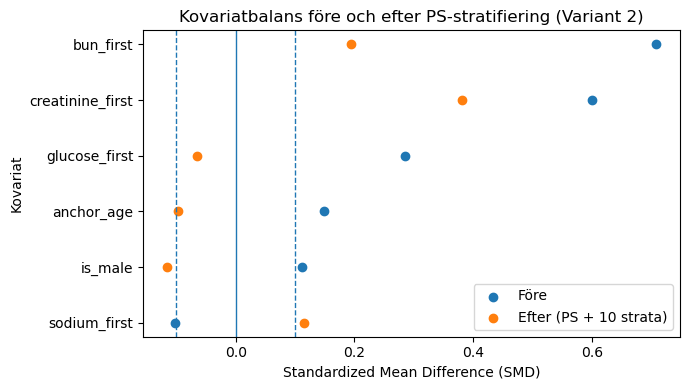

In [ ]:
tmp = df_smd_v2.copy().sort_values("|SMD_pre|", ascending=True)

plt.figure(figsize=(7,4))
plt.scatter(tmp["SMD_pre"], tmp.index, label="Före")
plt.scatter(tmp["SMD_post_10strata_PS"], tmp.index, label="Efter (PS + 10 strata)")
plt.axvline(0, linewidth=1)
plt.axvline(0.1, linestyle="--", linewidth=1)
plt.axvline(-0.1, linestyle="--", linewidth=1)
plt.xlabel("Standardized Mean Difference (SMD)")
plt.ylabel("Kovariat")
plt.title("Kovariatbalans före och efter PS-stratifiering (Variant 2)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
strata_col = "ps_stratum10_v2"
outcomes = ["died_30d", "died_90d", "died_1y"]

def standardized_risk(d, outcome_col, group_value, strata_col):
    strata_weights = d[strata_col].value_counts(normalize=True).sort_index()
    parts = []
    for s, w in strata_weights.items():
        ds = d[d[strata_col] == s]
        r = ds.loc[ds["high_cci"] == group_value, outcome_col].mean()
        if pd.isna(r):
            continue
        parts.append(w * float(r))
    return float(np.sum(parts))

rows = []
for oc in outcomes:
    d = df_v2.dropna(subset=[oc, "high_cci", strata_col]).copy()
    d["high_cci"] = d["high_cci"].astype(int)
    d[oc] = d[oc].astype(int)
    d[strata_col] = d[strata_col].astype(int)

    pre = d.groupby("high_cci")[oc].mean()
    pre0, pre1 = float(pre.loc[0]), float(pre.loc[1])

    post0 = standardized_risk(d, oc, 0, strata_col)
    post1 = standardized_risk(d, oc, 1, strata_col)

    rows.append([oc, "Före (rå)", pre0, pre1])
    rows.append([oc, "Efter (PS-strata std)", post0, post1])

df_plot_v2 = pd.DataFrame(rows, columns=["Outcome", "Typ", "Risk_low", "Risk_high"])
display(df_plot_v2)


,Outcome,Typ,Risk_low,Risk_high
0,died_30d,Före (rå),0.137317,0.253478
1,died_30d,Efter (PS-strata std),0.147866,0.206801
2,died_90d,Före (rå),0.190244,0.352396
3,died_90d,Efter (PS-strata std),0.204233,0.287954
4,died_1y,Före (rå),0.254146,0.496136
5,died_1y,Efter (PS-strata std),0.272004,0.423879


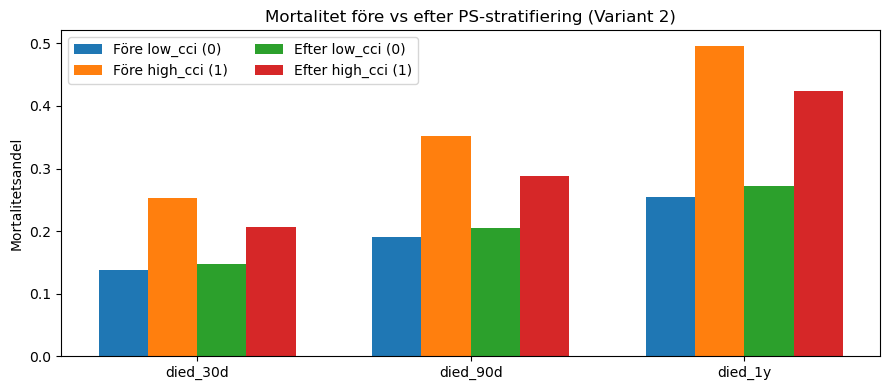

,Outcome,RD_pre,RD_post
0,died_30d,0.116161,0.058935
1,died_90d,0.162152,0.083722
2,died_1y,0.241990,0.151875


In [ ]:
outcomes = ["died_30d", "died_90d", "died_1y"]
x = np.arange(len(outcomes))
width = 0.18

pre_low  = df_plot_v2[df_plot_v2["Typ"]=="Före (rå)"]["Risk_low"].values
pre_high = df_plot_v2[df_plot_v2["Typ"]=="Före (rå)"]["Risk_high"].values
post_low = df_plot_v2[df_plot_v2["Typ"]=="Efter (PS-strata std)"]["Risk_low"].values
post_high= df_plot_v2[df_plot_v2["Typ"]=="Efter (PS-strata std)"]["Risk_high"].values

plt.figure(figsize=(9,4))
plt.bar(x - 1.5*width, pre_low,  width=width, label="Före low_cci (0)")
plt.bar(x - 0.5*width, pre_high, width=width, label="Före high_cci (1)")
plt.bar(x + 0.5*width, post_low, width=width, label="Efter low_cci (0)")
plt.bar(x + 1.5*width, post_high,width=width, label="Efter high_cci (1)")
plt.xticks(x, outcomes)
plt.ylabel("Mortalitetsandel")
plt.title("Mortalitet före vs efter PS-stratifiering (Variant 2)")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

summary = []
for i, oc in enumerate(outcomes):
    rd_pre  = pre_high[i] - pre_low[i]
    rd_post = post_high[i] - post_low[i]
    summary.append([oc, rd_pre, rd_post])

df_summary_v2 = pd.DataFrame(summary, columns=["Outcome", "RD_pre", "RD_post"])
display(df_summary_v2)


In [ ]:
display(df_v2.groupby("high_cci")["ps_v2"].describe()[["min","max","mean","std"]])


,min,max,mean,std
high_cci,,,,
0,0.039627,0.947106,0.123913,0.090360
1,0.054083,0.972745,0.215130,0.170591


In [ ]:
# EFTER balansering: strata-standardiserad risk (Variant 2)
strata_col = "ps_stratum10_v2"
outcomes = [("died_30d", 30), ("died_90d", 90), ("died_1y", 365)]

def standardized_risk(dsub, outcome_col, group_value, strata_col, group_col="high_cci"):
    strata_weights = dsub[strata_col].value_counts(normalize=True).sort_index()
    parts = []
    for s, w in strata_weights.items():
        ds = dsub[dsub[strata_col] == s]
        r = ds.loc[ds[group_col] == group_value, outcome_col].mean()
        if pd.isna(r):
            continue
        parts.append(w * float(r))
    return float(np.sum(parts))

rows = []
for oc, days in outcomes:
    d = df_v2.dropna(subset=[oc, "high_cci", strata_col]).copy()
    d["high_cci"] = d["high_cci"].astype(int)
    d[oc] = d[oc].astype(int)
    d[strata_col] = d[strata_col].astype(int)

    # Före (rå)
    pre = d.groupby("high_cci")[oc].mean()
    pre0, pre1 = float(pre.loc[0])*100, float(pre.loc[1])*100

    # Efter (strata-standardiserad)
    post0 = standardized_risk(d, oc, 0, strata_col)*100
    post1 = standardized_risk(d, oc, 1, strata_col)*100

    rows.append([days, "Kontrollgrupp", round(pre0,1), round(post0,1)])
    rows.append([days, "Riskgrupp",     round(pre1,1), round(post1,1)])

tab_mort_pre_post_v2 = pd.DataFrame(
    rows, columns=["Dagar", "Grupp", "Före (rå, %)", "Efter (PS-strata std, %)"]
).sort_values(["Grupp","Dagar"])

display(tab_mort_pre_post_v2)


,Dagar,Grupp,"Före (rå, %)","Efter (PS-strata std, %)"
0,30,Kontrollgrupp,13.7,14.8
2,90,Kontrollgrupp,19.0,20.4
4,365,Kontrollgrupp,25.4,27.2
1,30,Riskgrupp,25.3,20.7
3,90,Riskgrupp,35.2,28.8
5,365,Riskgrupp,49.6,42.4
